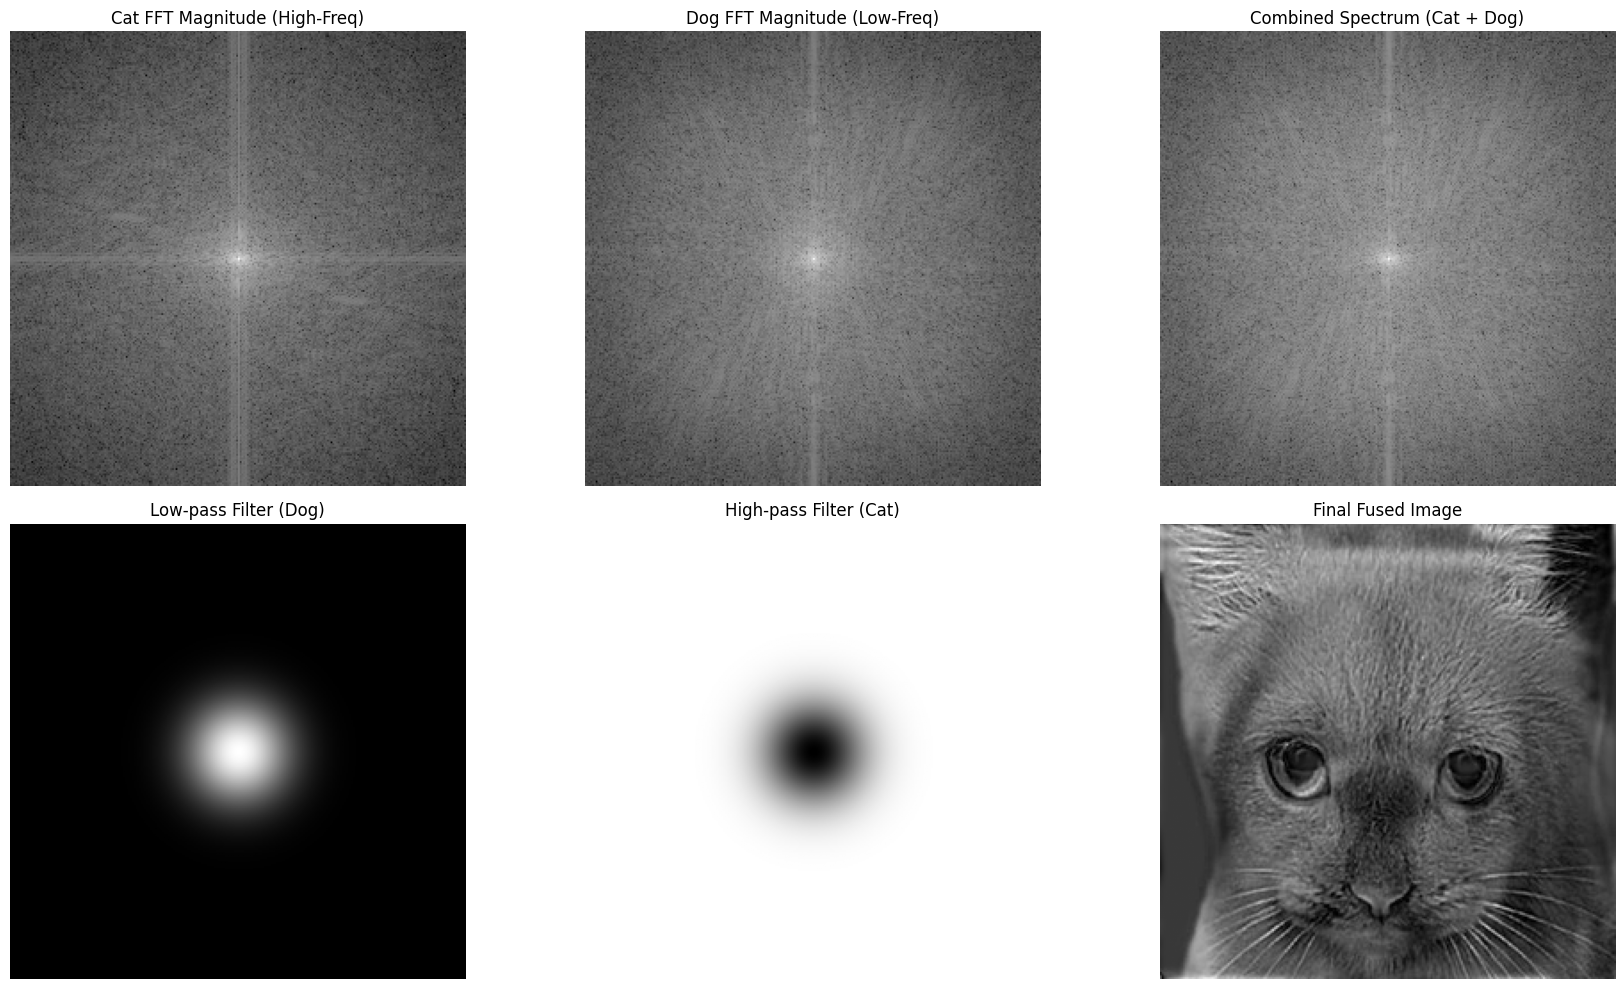

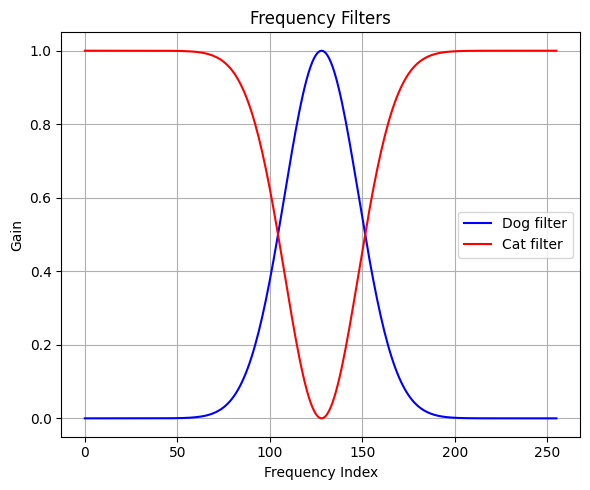

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Load and resize both images ---
dog = Image.open('/content/cat_gray.jpg').convert('L').resize((256, 256))
cat = Image.open('/content/dog_gray.jpg').convert('L').resize((256, 256))

cat_array = np.array(cat)
dog_array = np.array(dog)

# --- Compute FFT ---
cat_fft = np.fft.fft2(cat_array)
dog_fft = np.fft.fft2(dog_array)

cat_fft_shift = np.fft.fftshift(cat_fft)
dog_fft_shift = np.fft.fftshift(dog_fft)

# --- Gaussian filters ---
def gaussian_lowpass(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    distance = np.sqrt((X - ccol)**2 + (Y - crow)**2)
    gaussian = np.exp(-(distance**2) / (2 * (cutoff**2)))
    return gaussian

cutoff = 20
low_pass_filter = gaussian_lowpass(cat_array.shape, cutoff)
high_pass_filter = 1 - low_pass_filter

# --- Apply filters ---
boost_factor = 2.5
dog_low_freq = cat_fft_shift * low_pass_filter
cat_high_freq = dog_fft_shift * high_pass_filter * boost_factor
combined = dog_low_freq + cat_high_freq

# --- Inverse FFT ---
combined_ishift = np.fft.ifftshift(combined)
fused_img = np.fft.ifft2(combined_ishift)
fused_img_real = np.abs(fused_img)

# --- Magnitude spectra for plots ---
def log_magnitude_spectrum(freq_data):
    return 20 * np.log10(np.abs(freq_data) + 1)

cat_mag = log_magnitude_spectrum(cat_fft_shift)
dog_mag = log_magnitude_spectrum(dog_fft_shift)
cat_filtered_mag = log_magnitude_spectrum(cat_high_freq)
dog_filtered_mag = log_magnitude_spectrum(dog_low_freq)

# --- Plot full result ---
plt.figure(figsize=(18, 10))

# Original magnitude spectra
plt.subplot(2, 3, 1)
plt.imshow(cat_mag, cmap='gray')
plt.title("Cat FFT Magnitude (High-Freq)")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(dog_mag, cmap='gray')
plt.title("Dog FFT Magnitude (Low-Freq)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(log_magnitude_spectrum(combined), cmap='gray')
plt.title("Combined Spectrum (Cat + Dog)")
plt.axis('off')

# Filter transfer functions
plt.subplot(2, 3, 4)
plt.imshow(low_pass_filter, cmap='gray')
plt.title("Low-pass Filter (Dog)")
plt.axis('off')


plt.subplot(2, 3, 5)
plt.imshow(high_pass_filter, cmap='gray')
plt.title("High-pass Filter (Cat)")
plt.axis('off')


plt.subplot(2, 3, 6)
plt.imshow(fused_img_real, cmap='gray')
plt.title("Final Fused Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Extract 1D slices from the center of both filters
row = low_pass_filter.shape[0] // 2
low_pass_1d = low_pass_filter[row, :]
high_pass_1d = high_pass_filter[row, :]

# Plot frequency response profiles
plt.figure(figsize=(6, 5))
plt.plot(low_pass_1d, label='Dog filter', color='blue')
plt.plot(high_pass_1d, label='Cat filter', color='red')
plt.title("Frequency Filters")
plt.xlabel("Frequency Index")
plt.ylabel("Gain")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


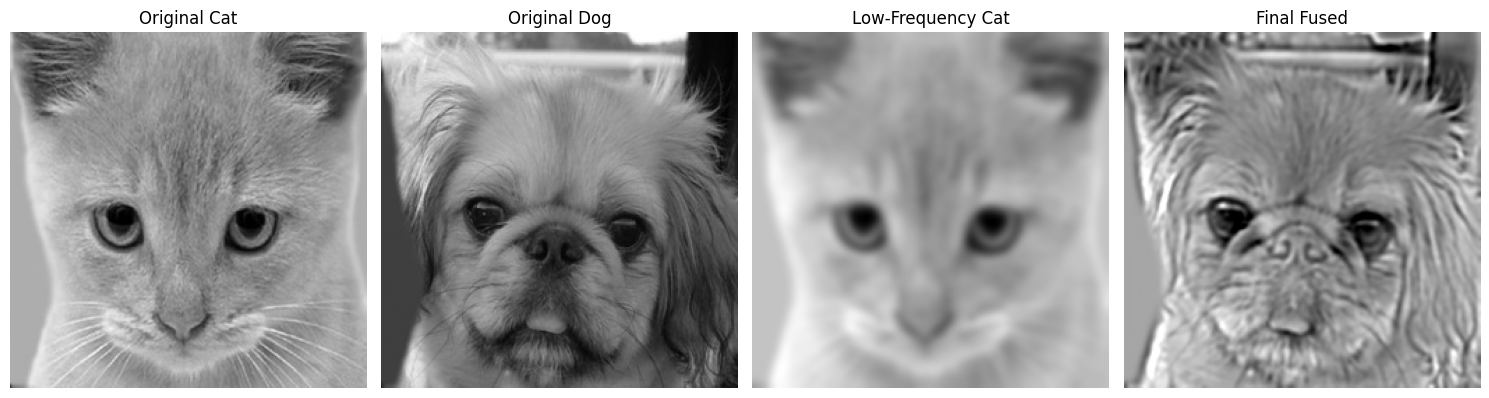

In [18]:
#code in which the dog is in high freq and the cat is in low freq. This output is not as clean as the other one

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import cv2

# Load images and convert to grayscale arrays
cat = Image.open('/content/cat_gray.jpg').convert('L').resize((256, 256))
dog = Image.open('/content/dog_gray.jpg').convert('L').resize((256, 256))

cat_array = np.array(cat).astype(float)
dog_array = np.array(dog).astype(float)

# --- Step 1: Create Low-Frequency Image (very blurred cat) ---
cat_blurred = cv2.GaussianBlur(cat_array, (31, 31), sigmaX=3)

# --- Step 2: Create High-Frequency Image (dog edges) ---
# dog_blurred = cv2.GaussianBlur(dog_array, (11, 11), sigmaX=5)
# dog_edges = dog_array - dog_blurred  # sharpened high-frequency features

dog_soft = cv2.GaussianBlur(dog_array, (5, 5), sigmaX=1.5)
dog_edges = dog_soft - cv2.GaussianBlur(dog_soft, (11, 11), sigmaX=4)

# Optional: scale edge contrast
dog_edges *= 4.0  # Boost high-frequency detail

# --- Step 3: Combine both ---
fused_image = cat_blurred + dog_edges
fused_image = np.clip(fused_image, 0, 255).astype(np.uint8)

# --- Step 4: Plot ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(cat_array, cmap='gray')
plt.title("Original Cat")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(dog_array, cmap='gray')
plt.title("Original Dog")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(cat_blurred, cmap='gray')
plt.title("Low-Frequency Cat")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(fused_image, cmap='gray')
plt.title("Final Fused")
plt.axis('off')

plt.tight_layout()
plt.show()